<img src="https://raw.githubusercontent.com/AdrianoPereira/CAP421/main/lectures/homework09/images/cover-data-augmentation.png" style="width: 100%;">

### OVERVIEW
<hr />

This notebook contains exercise 09 which deals with some data augmentation techniques for machine learning. This exercise was proposed by Professor Thales Körting in the discipline CAP421 - Deep Learning offered in the Graduate Program in Applied Computing at the National Institute for Space Research.

#### TABLE OF CONTENT
<hr />


**Author:** Adriano P. Almeida
<br>
**Created on:** 05 November, 2021

## 1. Import libraries

In [183]:
import io
import os
import shutil
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
from PIL import Image as pimage
import sklearn.utils as sutils
import math

In [236]:
SEED = 42
def set_seed():
    global SEED
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

In [3]:
PATH = "/home/adriano/CAP421/lectures/homework09"
FILENAME = os.path.join(PATH, f"data/euro_sat.zip")
URL = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
CHUNK_SIZE = 1024
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15
PATH_IMGS = os.path.join(PATH, f"data/images")
SPATH_IMGS = os.path.join(PATH, f"data/splitted")

In [4]:
def split_train_val_test(train_size, val_size, test_size, base_path, seed=SEED, verbose=True):
    filenames = []
    for root, _, files in os.walk(PATH_IMGS):
        for file in files:
            filenames.append(os.path.join(root, file))
    filenames = np.array(filenames)
    
    classes = {cls.split(os.sep)[-2] for cls in filenames}
    for cls in classes:
        train_path = os.path.join(base_path, f"train/{cls}")
        val_path = os.path.join(base_path, f"val/{cls}")
        test_path = os.path.join(base_path, f"test/{cls}")
        
        if not os.path.exists(train_path): os.makedirs(train_path)
        if not os.path.exists(val_path): os.makedirs(val_path)
        if not os.path.exists(test_path): os.makedirs(test_path)
        
    
    total_imgs = filenames.size
    train_idxs = (0, math.ceil(total_imgs*TRAIN_SIZE))
    val_idxs = (train_idxs[1], train_idxs[1]+math.ceil(total_imgs*VAL_SIZE))
    test_idxs = (val_idxs[1], val_idxs[1]+math.ceil(total_imgs*TEST_SIZE))

    shuffle_filenames = sutils.shuffle(filenames, random_state=seed)
    sub_folders = {
        'train': shuffle_filenames[train_idxs[0]:train_idxs[1]],
        'val': shuffle_filenames[val_idxs[0]:val_idxs[1]],
        'test': shuffle_filenames[test_idxs[0]:test_idxs[1]]
    }
    
    for folder, folder_filenames in sub_folders.items():
        if verbose:
            print(f"Copying {len(folder_filenames)} files to {base_path}/{folder}...")
            
        for src in folder_filenames:
            img = f'{os.sep}'.join(src.split(os.sep)[-2:])
            dst = f"{base_path}/{folder}/{img}"
            shutil.copyfile(src, dst)
        
        for cls in classes:
            path_cls = f"{base_path}/{folder}/{cls}"
            samples = len(os.listdir(path_cls))
            percent = f"{(100*samples/folder_filenames.size):.2f}%"
            if verbose:
                print(f"\tClass {cls}: {samples} files ({percent})")
        
  

In [5]:
def download_zipfile():
    print("Downloading Zipfile...")
    global FILENAME, URL, CHUNK_SIZE
    
    res = requests.get(URL, stream=True)
    
    with open(FILENAME, 'wb') as handle:
        for obj in res.iter_content(chunk_size=CHUNK_SIZE):
            handle.write(obj)
    
    
def extract_zipfile():
    print("Extracting Zipfile...")
    global PATH_IMGS, FILENAME
    
    with zipfile.ZipFile(FILENAME, 'r') as handle:
        handle.extractall(PATH_IMGS)
        
        
def check_files():
    print("Checking files...")
    if not os.path.exists(SPATH_IMGS):
        print("Sub folder Images not found...")
        if not os.path.exists(PATH_IMGS):
            print("Image base path not found...")
            if not os.path.exists(FILENAME):
                print("Zipfile not found...")
                download_zipfile()
            os.makedirs(PATH_IMGS)
            extract_zipfile()
        split_train_val_test(TRAIN_SIZE, VAL_SIZE, TEST_SIZE, SPATH_IMGS)  
    print("Done!")
    
    
check_files()

Checking files...
Done!


In [472]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

it = data_gen.flow_from_directory(
    f"{SPATH_IMGS}/train",
    batch_size=64,
    target_size=(256, 256), 
    color_mode='rgb',
    seed=SEED
)

img = next(it)
idx = 40
class_name = list(it.class_indices.keys())[np.argmax(img[1][idx])]
sample_image = img[0][idx]
idx, class_name

Found 18900 images belonging to 10 classes.


(40, 'Pasture')

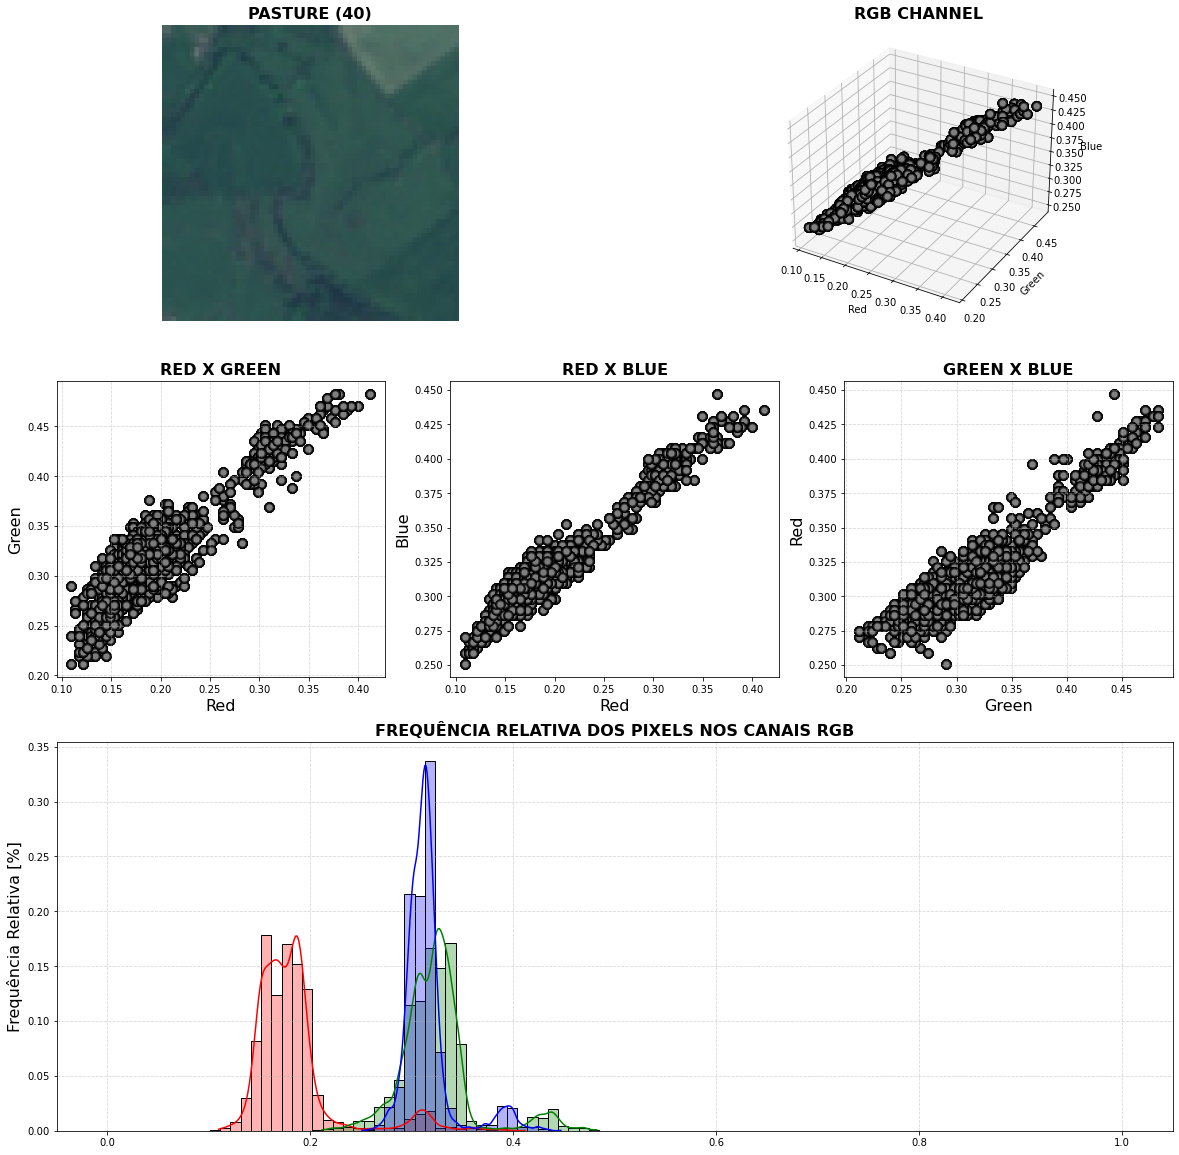

In [473]:
r = img[0][idx][:, :, 0].ravel()
g = img[0][idx][:, :, 1].ravel()
b = img[0][idx][:, :, 2].ravel()
bins = np.linspace(0, 1, 100)


fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(2, 2, 1)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"{class_name} ({idx})".upper(), fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(sample_image)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.grid(ls='--', alpha=0.5)
ax.set_title("RGB CHANNEL", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter3D(r, g, b, s=70, lw=2, ec='k', color='grey', alpha=0.5)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')


ax = fig.add_subplot(2, 3, 4)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Green", fontsize=16)
ax.set_title("RED X GREEN", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, g, s=70, lw=2, ec='k', color='grey', alpha=0.5)

ax = fig.add_subplot(2, 3, 5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Blue", fontsize=16)
ax.set_title("RED X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, b, s=70, lw=2, ec='k', color='grey', alpha=0.5)


ax = fig.add_subplot(2, 3, 6)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Green", fontsize=16)
ax.set_ylabel("Red", fontsize=16)
ax.set_title("GREEN X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(g, b, s=70, lw=2, ec='k', color='grey', alpha=0.5)


# ax = fig.add_axes([0.15, -0.3, 0.75, 0.4])
ax = fig.add_axes([0.125, -0.4, 0.775, 0.45])
ax.set_title("FREQUÊNCIA RELATIVA DOS PIXELS NOS CANAIS RGB", 
             fontdict={'size': 16, 'weight': 'bold'})
ax.set_ylabel("Frequência Relativa [%]", fontsize=16)
sns.histplot(
    r, label='Red', log_scale=False, stat="probability", 
    color='red', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.3, ax=ax
)
sns.histplot(
    g, label='Green', log_scale=False, stat="probability", 
    color='green', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.3, ax=ax
)
sns.histplot(
    b, label='Blue', log_scale=False, stat="probability", 
    color='blue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.3, ax=ax
)
ax.grid(ls='--', alpha=0.5)

## Rotation

In [292]:
print(help(tf.keras.layers.experimental.preprocessing.RandomRotation))

Help on class RandomRotation in module tensorflow.python.keras.layers.preprocessing.image_preprocessing:

class RandomRotation(tensorflow.python.keras.engine.base_preprocessing_layer.PreprocessingLayer)
 |  RandomRotation(*args, **kwargs)
 |  
 |  Randomly rotate each image.
 |  
 |  By default, random rotations are only applied during training.
 |  At inference time, the layer does nothing. If you need to apply random
 |  rotations at inference time, set `training` to True when calling the layer.
 |  
 |  Input shape:
 |    4D tensor with shape:
 |    `(samples, height, width, channels)`, data_format='channels_last'.
 |  
 |  Output shape:
 |    4D tensor with shape:
 |    `(samples, height, width, channels)`, data_format='channels_last'.
 |  
 |  Attributes:
 |    factor: a float represented as fraction of 2pi, or a tuple of size
 |      2 representing lower and upper bound for rotating clockwise and
 |      counter-clockwise. A positive values means rotating counter clock-wise,
 |  

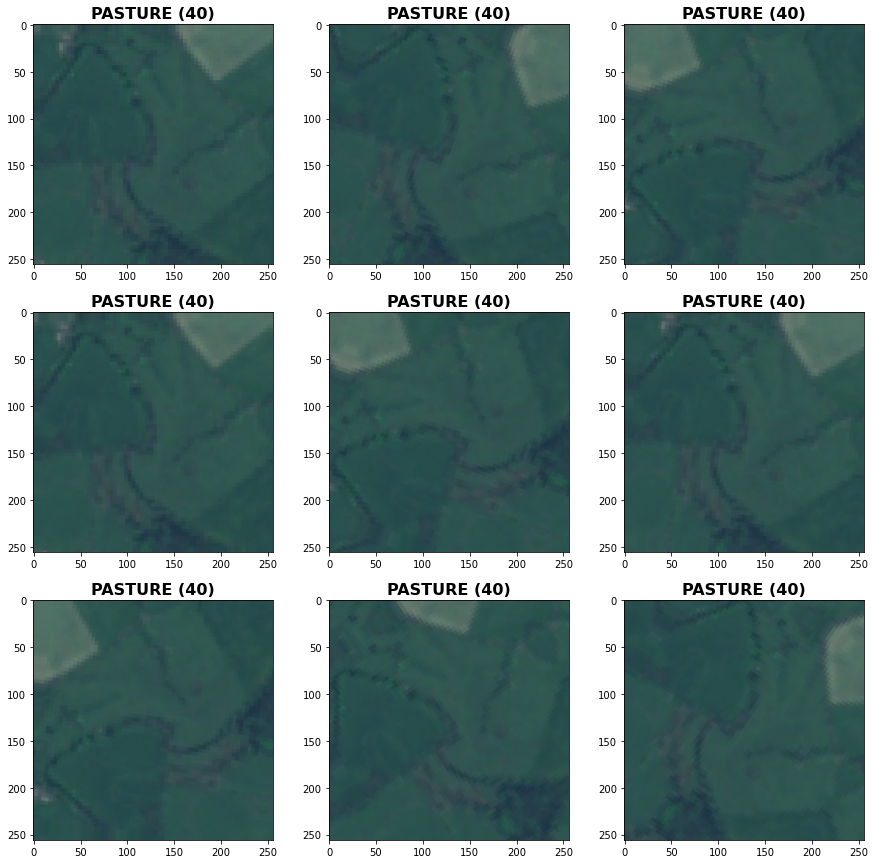

In [474]:
set_seed()
random_rotation_DA = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(
        factor=0.25, 
        fill_mode='reflect', 
        interpolation='bilinear',
        fill_value=0.0
    )
])

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3*3):
    row = i//3
    col = i%3
    ax[row][col].set_title(f"{class_name} ({idx})".upper(), fontdict={'size': 16, 'weight': 'bold'})
    if row + col == 0:
        ax[row][col].imshow(sample_image)
    else:
        image_da = random_rotation_DA(
            tf.expand_dims(sample_image, axis=0)
        )[0, :, :, :]
        ax[row][col].imshow(image_da)
    

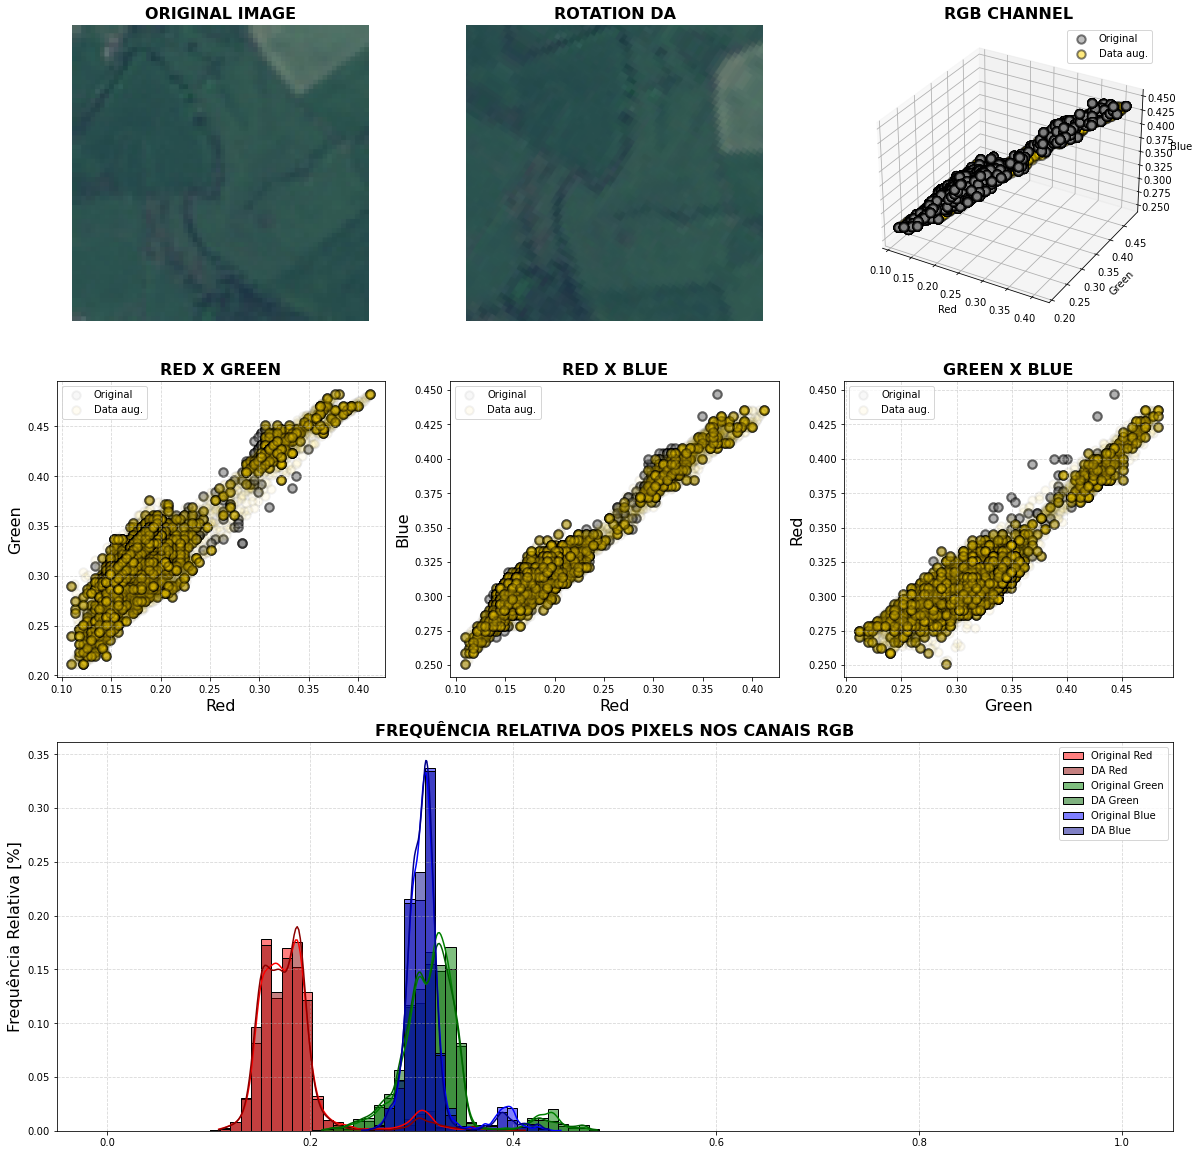

In [475]:
r_da = image_da[:, :, 0].numpy().ravel()
g_da = image_da[:, :, 1].numpy().ravel()
b_da = image_da[:, :, 2].numpy().ravel()

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(2, 3, 1)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"ORIGINAL IMAGE", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(sample_image)
ax.axis('off')

ax = fig.add_subplot(2, 3, 2)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"ROTATION DA", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(image_da)
ax.axis('off')

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.grid(ls='--', alpha=0.5)
ax.set_title("RGB CHANNEL", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter3D(r, g, b, s=70, lw=2, ec='k', color='grey', alpha=0.5, label='Original')
ax.scatter3D(r_da, g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.5, label='Data aug.')
ax.legend()
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')


ax = fig.add_subplot(2, 3, 4)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Green", fontsize=16)
ax.set_title("RED X GREEN", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, g, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, g_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Blue", fontsize=16)
ax.set_title("RED X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 6)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Green", fontsize=16)
ax.set_ylabel("Red", fontsize=16)
ax.set_title("GREEN X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(g, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

# ax = fig.add_axes([0.15, -0.3, 0.75, 0.4])
ax = fig.add_axes([0.125, -0.4, 0.775, 0.45])
ax.set_title("FREQUÊNCIA RELATIVA DOS PIXELS NOS CANAIS RGB", 
             fontdict={'size': 16, 'weight': 'bold'})
ax.set_ylabel("Frequência Relativa [%]", fontsize=16)
sns.histplot(
    r, label='Original Red', log_scale=False, stat="probability", 
    color='red', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    r_da, label='DA Red', log_scale=False, stat="probability", 
    color='darkred', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    g, label='Original Green', log_scale=False, stat="probability", 
    color='green', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    g_da, label='DA Green', log_scale=False, stat="probability", 
    color='darkgreen', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    b, label='Original Blue', log_scale=False, stat="probability", 
    color='blue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    b_da, label='DA Blue', log_scale=False, stat="probability", 
    color='darkblue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

ax.grid(ls='--', alpha=0.5)
ax.legend()

## Flip

In [293]:
print(help(tf.keras.layers.experimental.preprocessing.RandomFlip))

Help on class RandomFlip in module tensorflow.python.keras.layers.preprocessing.image_preprocessing:

class RandomFlip(tensorflow.python.keras.engine.base_preprocessing_layer.PreprocessingLayer)
 |  RandomFlip(*args, **kwargs)
 |  
 |  Randomly flip each image horizontally and vertically.
 |  
 |  This layer will flip the images based on the `mode` attribute.
 |  During inference time, the output will be identical to input. Call the layer
 |  with `training=True` to flip the input.
 |  
 |  Input shape:
 |    4D tensor with shape:
 |    `(samples, height, width, channels)`, data_format='channels_last'.
 |  
 |  Output shape:
 |    4D tensor with shape:
 |    `(samples, height, width, channels)`, data_format='channels_last'.
 |  
 |  Attributes:
 |    mode: String indicating which flip mode to use. Can be "horizontal",
 |      "vertical", or "horizontal_and_vertical". Defaults to
 |      "horizontal_and_vertical". "horizontal" is a left-right flip and
 |      "vertical" is a top-bottom 

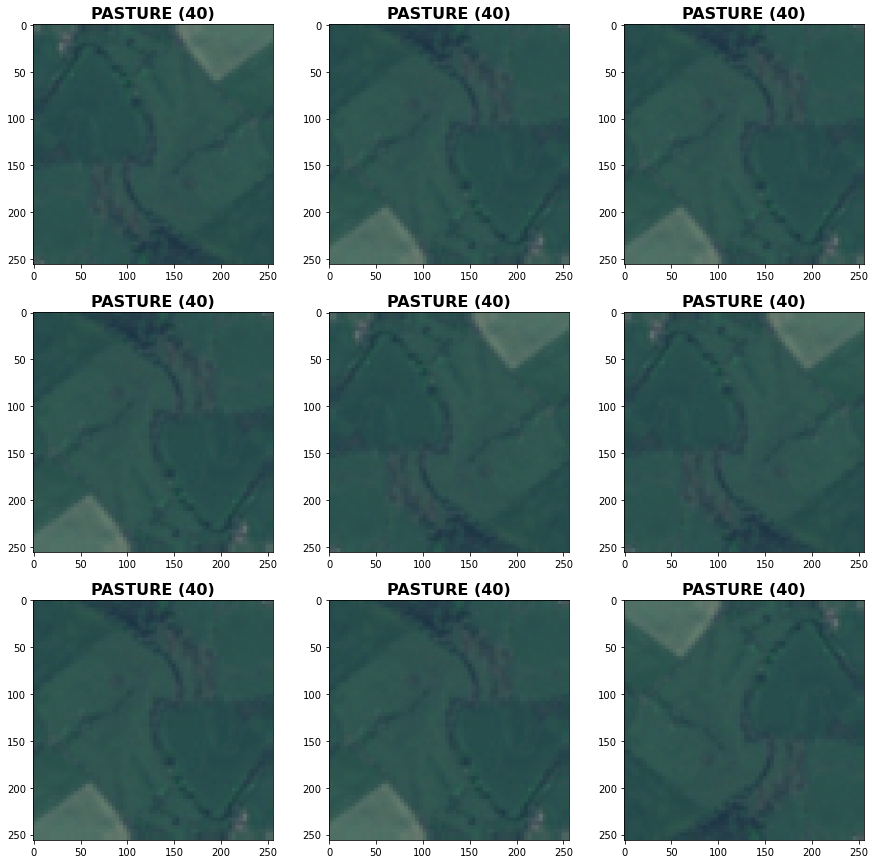

In [476]:
set_seed()
random_flip_DA = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(
        mode='horizontal_and_vertical'
    )
])

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3*3):
    row = i//3
    col = i%3
    ax[row][col].set_title(f"{class_name} ({idx})".upper(), fontdict={'size': 16, 'weight': 'bold'})
    if row + col == 0:
        ax[row][col].imshow(sample_image)
    else:
        image_da = random_flip_DA(
            tf.expand_dims(sample_image, axis=0)
        )[0, :, :, :]
        ax[row][col].imshow(image_da)
    

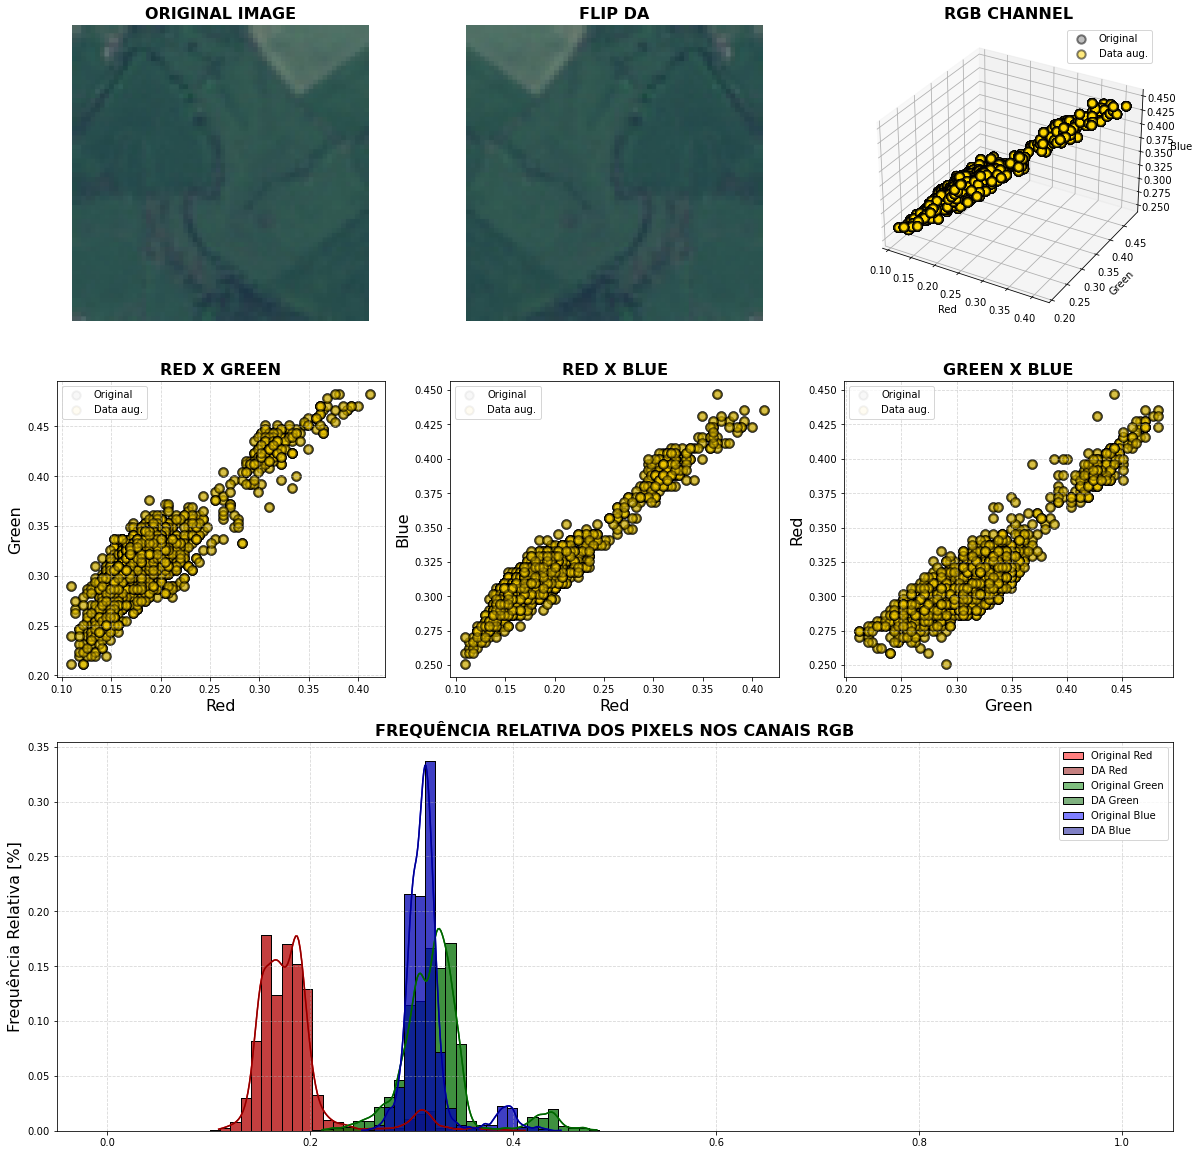

In [477]:
r_da = image_da[:, :, 0].numpy().ravel()
g_da = image_da[:, :, 1].numpy().ravel()
b_da = image_da[:, :, 2].numpy().ravel()

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(2, 3, 1)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"ORIGINAL IMAGE", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(sample_image)
ax.axis('off')

ax = fig.add_subplot(2, 3, 2)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"FLIP DA", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(image_da)
ax.axis('off')

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.grid(ls='--', alpha=0.5)
ax.set_title("RGB CHANNEL", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter3D(r, g, b, s=70, lw=2, ec='k', color='grey', alpha=0.5, label='Original')
ax.scatter3D(r_da, g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.5, label='Data aug.')
ax.legend()
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')


ax = fig.add_subplot(2, 3, 4)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Green", fontsize=16)
ax.set_title("RED X GREEN", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, g, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, g_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Blue", fontsize=16)
ax.set_title("RED X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 6)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Green", fontsize=16)
ax.set_ylabel("Red", fontsize=16)
ax.set_title("GREEN X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(g, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

# ax = fig.add_axes([0.15, -0.3, 0.75, 0.4])
ax = fig.add_axes([0.125, -0.4, 0.775, 0.45])
ax.set_title("FREQUÊNCIA RELATIVA DOS PIXELS NOS CANAIS RGB", 
             fontdict={'size': 16, 'weight': 'bold'})
ax.set_ylabel("Frequência Relativa [%]", fontsize=16)
sns.histplot(
    r, label='Original Red', log_scale=False, stat="probability", 
    color='red', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    r_da, label='DA Red', log_scale=False, stat="probability", 
    color='darkred', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    g, label='Original Green', log_scale=False, stat="probability", 
    color='green', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    g_da, label='DA Green', log_scale=False, stat="probability", 
    color='darkgreen', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    b, label='Original Blue', log_scale=False, stat="probability", 
    color='blue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    b_da, label='DA Blue', log_scale=False, stat="probability", 
    color='darkblue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

ax.grid(ls='--', alpha=0.5)
ax.legend()

## Zoom

In [291]:
help(tf.keras.layers.experimental.preprocessing.RandomZoom)

Help on class RandomZoom in module tensorflow.python.keras.layers.preprocessing.image_preprocessing:

class RandomZoom(tensorflow.python.keras.engine.base_preprocessing_layer.PreprocessingLayer)
 |  RandomZoom(*args, **kwargs)
 |  
 |  Randomly zoom each image during training.
 |  
 |  Arguments:
 |    height_factor: a float represented as fraction of value, or a tuple
 |      of size 2 representing lower and upper bound for zooming vertically.
 |      When represented as a single float, this value is used for both the
 |      upper and lower bound. A positive value means zooming out, while a
 |      negative value means zooming in.
 |      For instance, `height_factor=(0.2, 0.3)` result in an output zoomed out
 |      by a random amount in the range [+20%, +30%].
 |      `height_factor=(-0.3, -0.2)` result in an output zoomed in by a random
 |      amount in the range [+20%, +30%].
 |    width_factor: a float represented as fraction of value, or a tuple
 |      of size 2 representing 

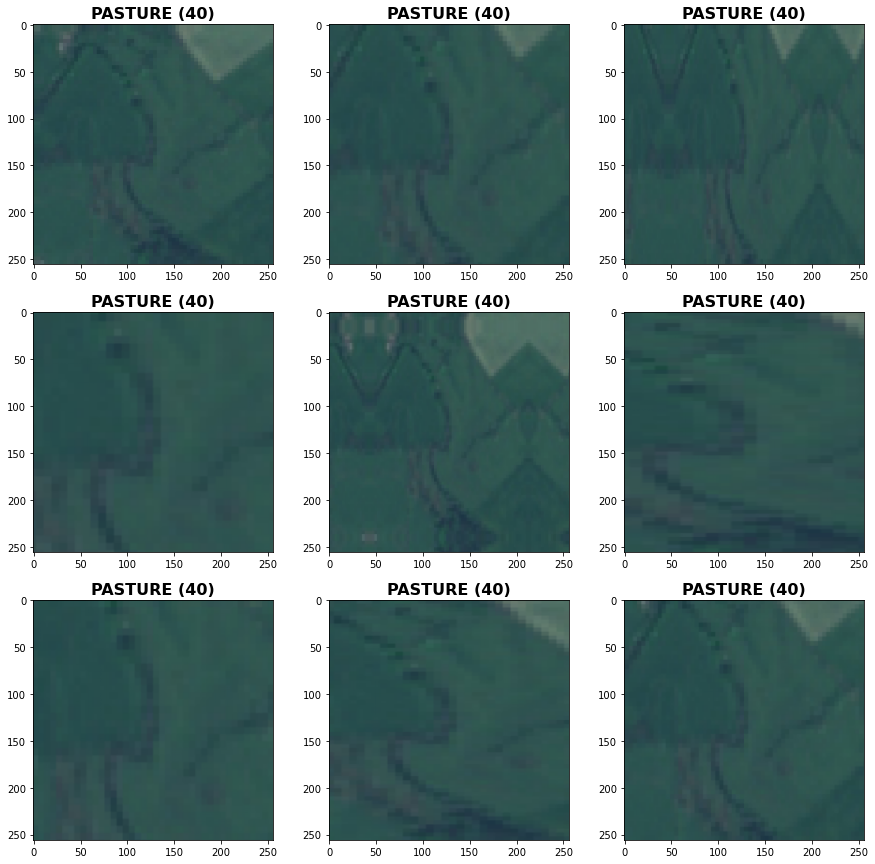

In [478]:
set_seed()
random_zoom_DA = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(
        height_factor=0.5, 
        width_factor=0.75, 
        fill_mode='reflect',
        interpolation='bilinear'
        
    )
])

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3*3):
    row = i//3
    col = i%3
    ax[row][col].set_title(f"{class_name} ({idx})".upper(), fontdict={'size': 16, 'weight': 'bold'})
    if row + col == 0:
        ax[row][col].imshow(sample_image)
    else:
        image_da = random_zoom_DA(
            tf.expand_dims(sample_image, axis=0)
        )[0, :, :, :]
        ax[row][col].imshow(image_da)
    

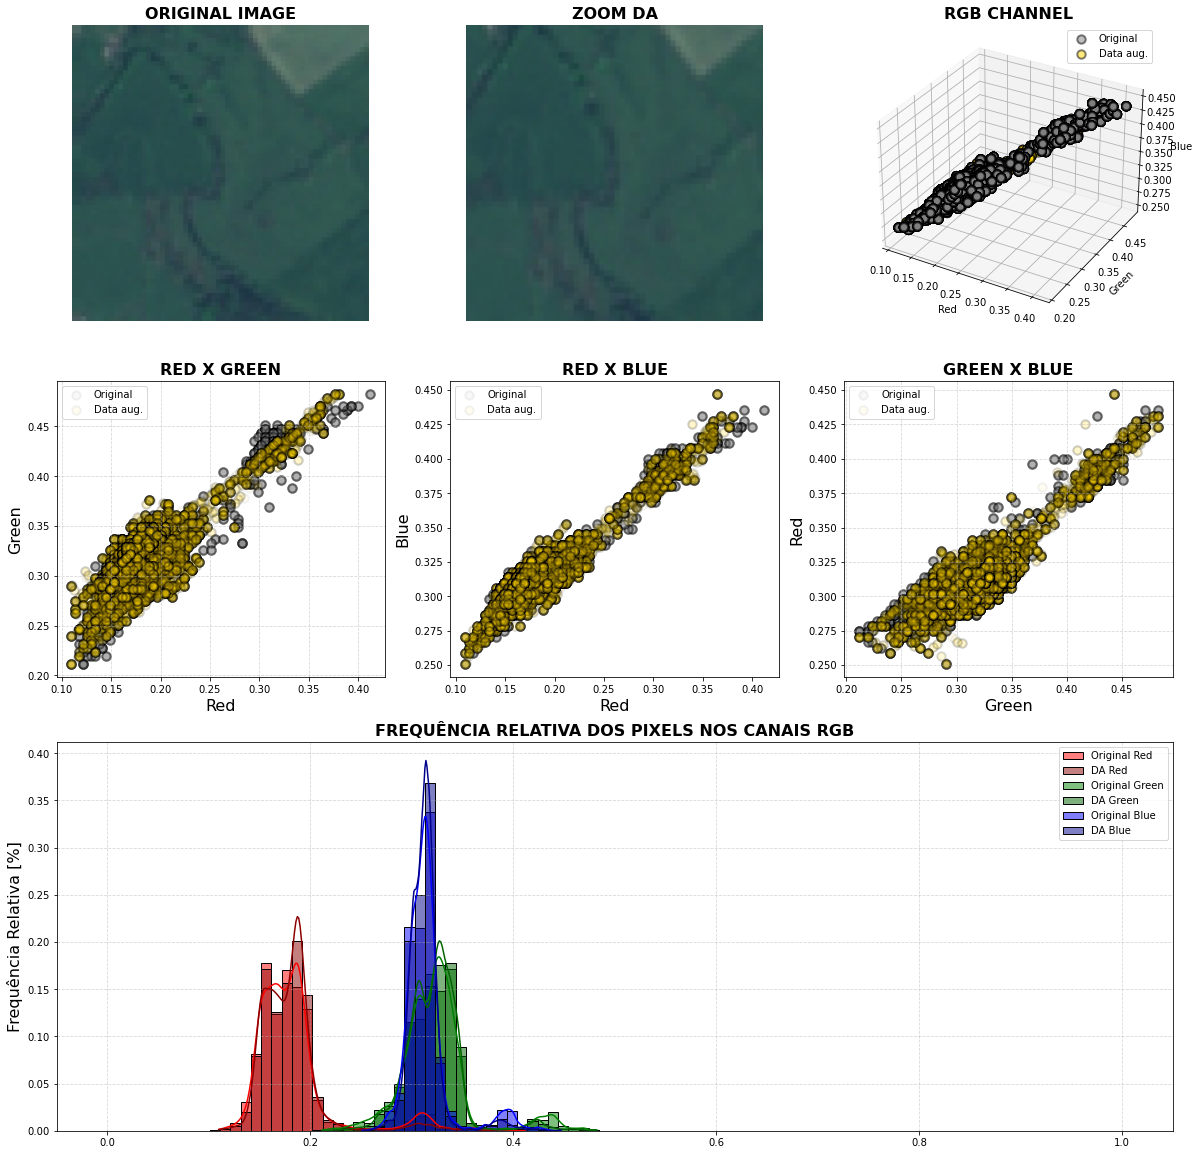

In [479]:
r_da = image_da[:, :, 0].numpy().ravel()
g_da = image_da[:, :, 1].numpy().ravel()
b_da = image_da[:, :, 2].numpy().ravel()

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(2, 3, 1)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"ORIGINAL IMAGE", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(sample_image)
ax.axis('off')

ax = fig.add_subplot(2, 3, 2)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"ZOOM DA", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(image_da)
ax.axis('off')

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.grid(ls='--', alpha=0.5)
ax.set_title("RGB CHANNEL", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter3D(r, g, b, s=70, lw=2, ec='k', color='grey', alpha=0.5, label='Original')
ax.scatter3D(r_da, g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.5, label='Data aug.')
ax.legend()
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')


ax = fig.add_subplot(2, 3, 4)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Green", fontsize=16)
ax.set_title("RED X GREEN", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, g, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, g_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Blue", fontsize=16)
ax.set_title("RED X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 6)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Green", fontsize=16)
ax.set_ylabel("Red", fontsize=16)
ax.set_title("GREEN X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(g, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_axes([0.125, -0.4, 0.775, 0.45])
ax.set_title("FREQUÊNCIA RELATIVA DOS PIXELS NOS CANAIS RGB", 
             fontdict={'size': 16, 'weight': 'bold'})
ax.set_ylabel("Frequência Relativa [%]", fontsize=16)
sns.histplot(
    r, label='Original Red', log_scale=False, stat="probability", 
    color='red', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    r_da, label='DA Red', log_scale=False, stat="probability", 
    color='darkred', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    g, label='Original Green', log_scale=False, stat="probability", 
    color='green', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    g_da, label='DA Green', log_scale=False, stat="probability", 
    color='darkgreen', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    b, label='Original Blue', log_scale=False, stat="probability", 
    color='blue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    b_da, label='DA Blue', log_scale=False, stat="probability", 
    color='darkblue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

ax.grid(ls='--', alpha=0.5)
ax.legend()

## Contrast

In [480]:
print(help(tf.keras.layers.experimental.preprocessing.RandomContrast))

Help on class RandomContrast in module tensorflow.python.keras.layers.preprocessing.image_preprocessing:

class RandomContrast(tensorflow.python.keras.engine.base_preprocessing_layer.PreprocessingLayer)
 |  RandomContrast(*args, **kwargs)
 |  
 |  Adjust the contrast of an image or images by a random factor.
 |  
 |  Contrast is adjusted independently for each channel of each image during
 |  training.
 |  
 |  For each channel, this layer computes the mean of the image pixels in the
 |  channel and then adjusts each component `x` of each pixel to
 |  `(x - mean) * contrast_factor + mean`.
 |  
 |  Input shape:
 |    4D tensor with shape:
 |    `(samples, height, width, channels)`, data_format='channels_last'.
 |  
 |  Output shape:
 |    4D tensor with shape:
 |    `(samples, height, width, channels)`, data_format='channels_last'.
 |  
 |  Attributes:
 |    factor: a positive float represented as fraction of value, or a tuple of
 |      size 2 representing lower and upper bound. When 

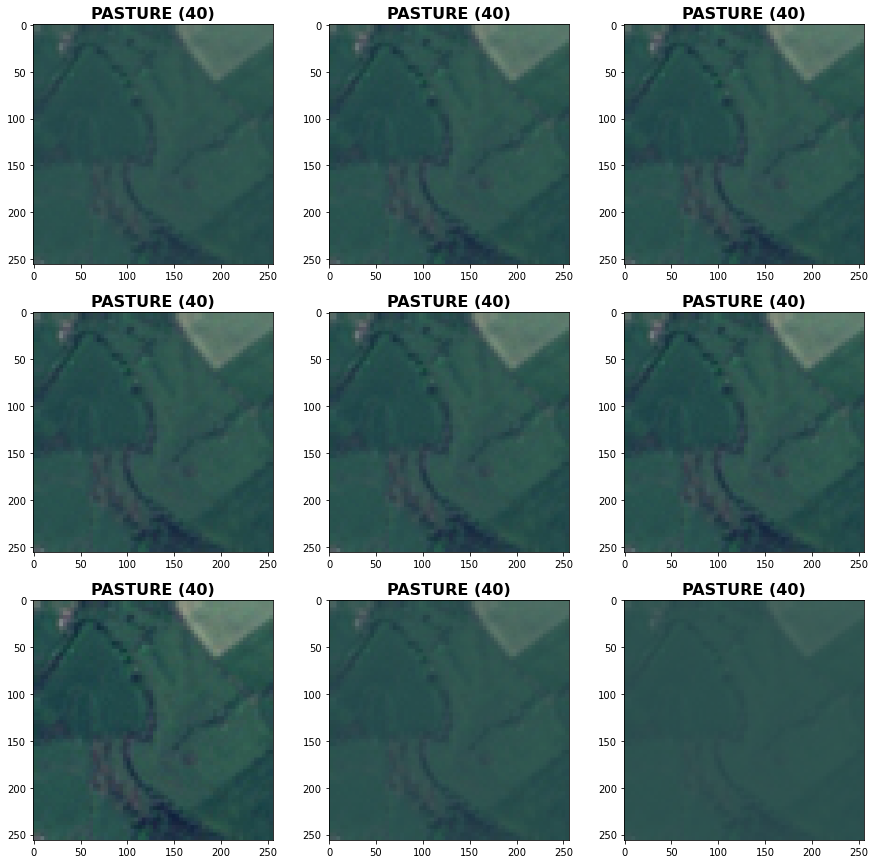

In [481]:
set_seed()
random_contrast_DA = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(
        factor=0.8
    )
])

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3*3):
    row = i//3
    col = i%3
    ax[row][col].set_title(f"{class_name} ({idx})".upper(), fontdict={'size': 16, 'weight': 'bold'})
    if row + col == 0:
        ax[row][col].imshow(sample_image)
    else:
        image_da = random_contrast_DA(
            tf.expand_dims(sample_image, axis=0)
        )[0, :, :, :]
        ax[row][col].imshow(image_da)
    

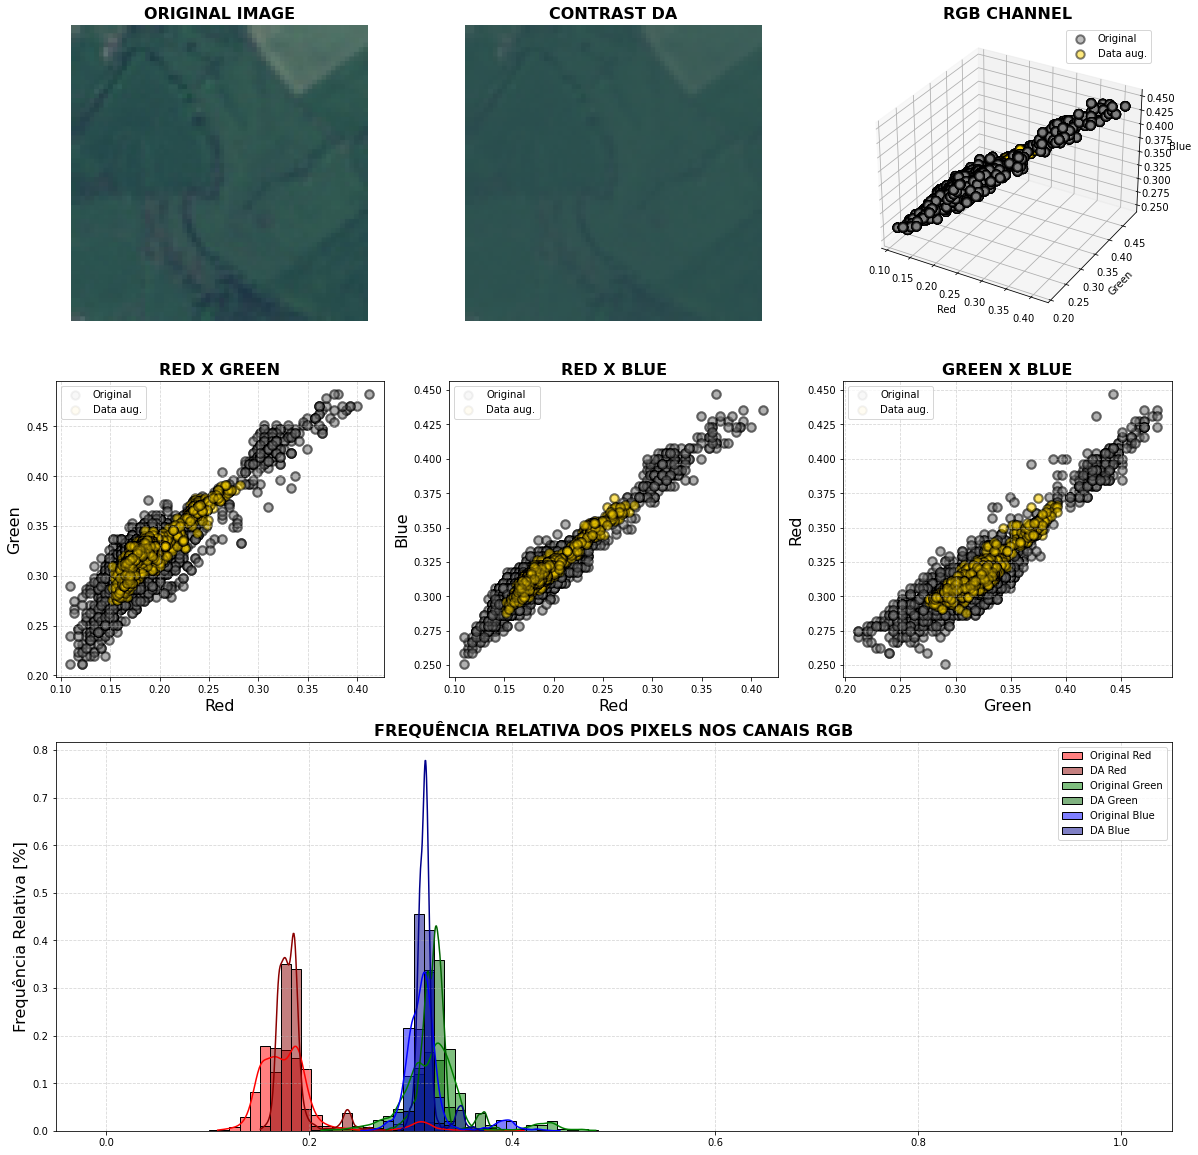

In [482]:
r_da = image_da[:, :, 0].numpy().ravel()
g_da = image_da[:, :, 1].numpy().ravel()
b_da = image_da[:, :, 2].numpy().ravel()

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(2, 3, 1)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"ORIGINAL IMAGE", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(sample_image)
ax.axis('off')

ax = fig.add_subplot(2, 3, 2)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"CONTRAST DA", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(image_da)
ax.axis('off')

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.grid(ls='--', alpha=0.5)
ax.set_title("RGB CHANNEL", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter3D(r, g, b, s=70, lw=2, ec='k', color='grey', alpha=0.5, label='Original')
ax.scatter3D(r_da, g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.5, label='Data aug.')
ax.legend()
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')


ax = fig.add_subplot(2, 3, 4)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Green", fontsize=16)
ax.set_title("RED X GREEN", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, g, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, g_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Blue", fontsize=16)
ax.set_title("RED X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 6)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Green", fontsize=16)
ax.set_ylabel("Red", fontsize=16)
ax.set_title("GREEN X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(g, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_axes([0.125, -0.4, 0.775, 0.45])
ax.set_title("FREQUÊNCIA RELATIVA DOS PIXELS NOS CANAIS RGB", 
             fontdict={'size': 16, 'weight': 'bold'})
ax.set_ylabel("Frequência Relativa [%]", fontsize=16)
sns.histplot(
    r, label='Original Red', log_scale=False, stat="probability", 
    color='red', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    r_da, label='DA Red', log_scale=False, stat="probability", 
    color='darkred', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    g, label='Original Green', log_scale=False, stat="probability", 
    color='green', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    g_da, label='DA Green', log_scale=False, stat="probability", 
    color='darkgreen', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    b, label='Original Blue', log_scale=False, stat="probability", 
    color='blue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    b_da, label='DA Blue', log_scale=False, stat="probability", 
    color='darkblue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

ax.grid(ls='--', alpha=0.5)
ax.legend()

## Brihtness

In [304]:
print(help(tf.image.random_brightness))

Help on function random_brightness in module tensorflow.python.ops.image_ops_impl:

random_brightness(image, max_delta, seed=None)
    Adjust the brightness of images by a random factor.
    
    Equivalent to `adjust_brightness()` using a `delta` randomly picked in the
    interval `[-max_delta, max_delta)`.
    
    Args:
      image: An image or images to adjust.
      max_delta: float, must be non-negative.
      seed: A Python integer. Used to create a random seed. See
        `tf.compat.v1.set_random_seed` for behavior.
    
    Usage Example:
    
    >>> x = [[[1.0, 2.0, 3.0],
    ...       [4.0, 5.0, 6.0]],
    ...      [[7.0, 8.0, 9.0],
    ...       [10.0, 11.0, 12.0]]]
    >>> tf.image.random_brightness(x, 0.2)
    <tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=...>
    
    Returns:
      The brightness-adjusted image(s).
    
    Raises:
      ValueError: if `max_delta` is negative.

None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


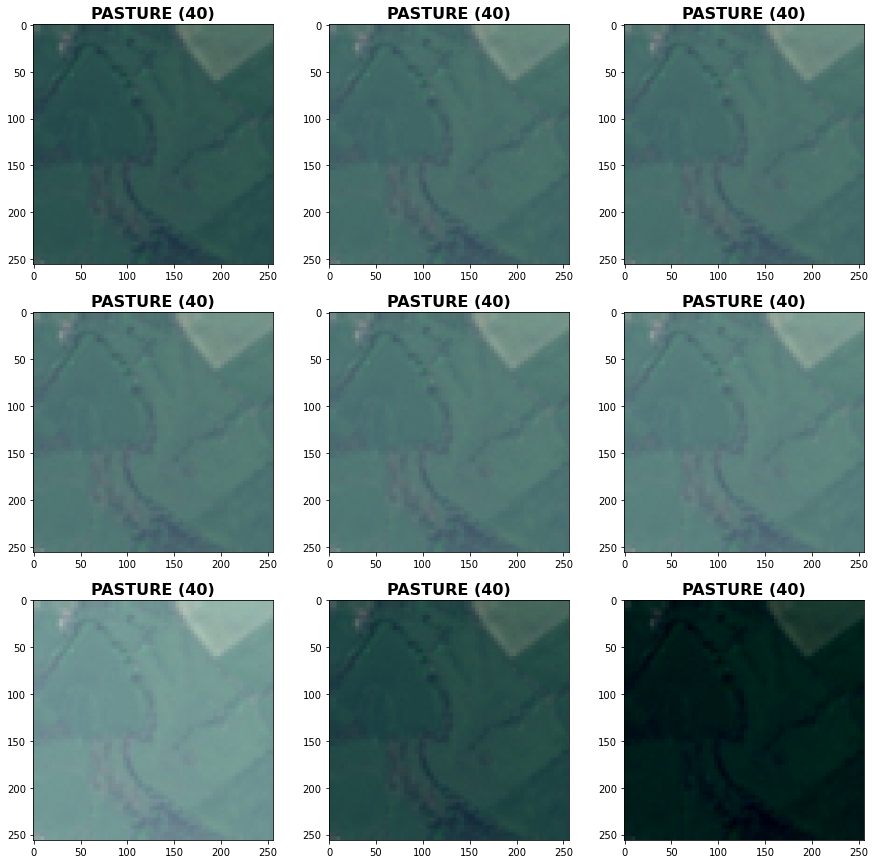

In [486]:
set_seed()
random_brightness_DA = lambda image: tf.image.random_brightness(image, max_delta=0.3)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3*3):
    row = i//3
    col = i%3
    ax[row][col].set_title(f"{class_name} ({idx})".upper(), fontdict={'size': 16, 'weight': 'bold'})
    if row + col == 0:
        ax[row][col].imshow(sample_image)
    else:
        image_da = random_brightness_DA(
            tf.expand_dims(sample_image, axis=0)
        )[0, :, :, :]
        ax[row][col].imshow(image_da)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


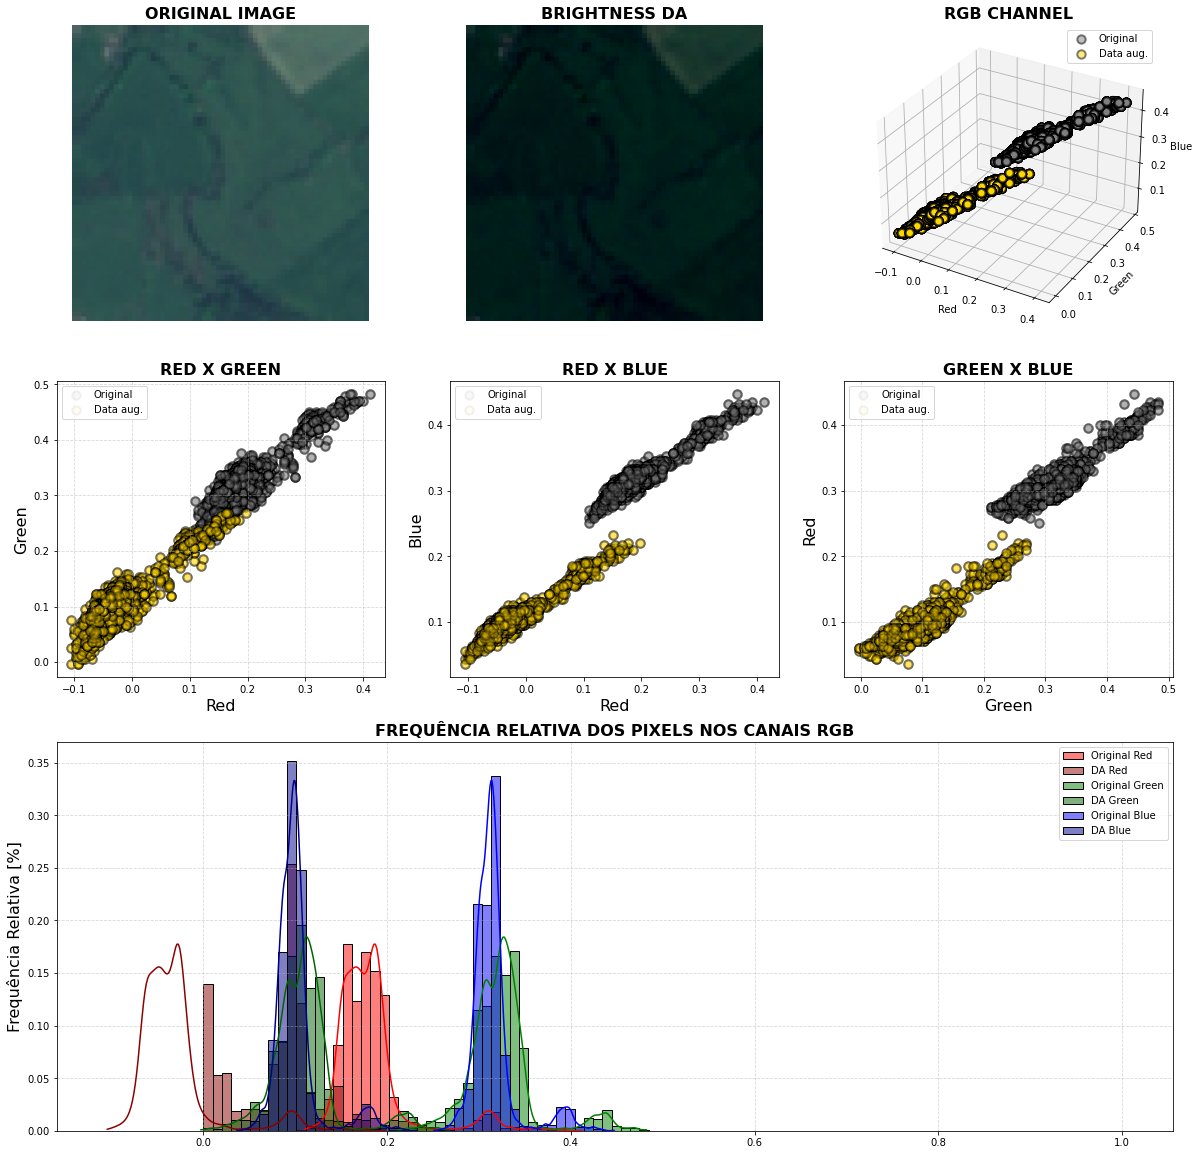

In [487]:
r_da = image_da[:, :, 0].numpy().ravel()
g_da = image_da[:, :, 1].numpy().ravel()
b_da = image_da[:, :, 2].numpy().ravel()

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(2, 3, 1)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"ORIGINAL IMAGE", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(sample_image)
ax.axis('off')

ax = fig.add_subplot(2, 3, 2)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"BRIGHTNESS DA", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(image_da)
ax.axis('off')

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.grid(ls='--', alpha=0.5)
ax.set_title("RGB CHANNEL", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter3D(r, g, b, s=70, lw=2, ec='k', color='grey', alpha=0.5, label='Original')
ax.scatter3D(r_da, g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.5, label='Data aug.')
ax.legend()
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')


ax = fig.add_subplot(2, 3, 4)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Green", fontsize=16)
ax.set_title("RED X GREEN", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, g, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, g_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Blue", fontsize=16)
ax.set_title("RED X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 6)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Green", fontsize=16)
ax.set_ylabel("Red", fontsize=16)
ax.set_title("GREEN X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(g, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_axes([0.125, -0.4, 0.775, 0.45])
ax.set_title("FREQUÊNCIA RELATIVA DOS PIXELS NOS CANAIS RGB", 
             fontdict={'size': 16, 'weight': 'bold'})
ax.set_ylabel("Frequência Relativa [%]", fontsize=16)
sns.histplot(
    r, label='Original Red', log_scale=False, stat="probability", 
    color='red', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    r_da, label='DA Red', log_scale=False, stat="probability", 
    color='darkred', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    g, label='Original Green', log_scale=False, stat="probability", 
    color='green', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    g_da, label='DA Green', log_scale=False, stat="probability", 
    color='darkgreen', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    b, label='Original Blue', log_scale=False, stat="probability", 
    color='blue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    b_da, label='DA Blue', log_scale=False, stat="probability", 
    color='darkblue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

ax.grid(ls='--', alpha=0.5)
ax.legend()

## HUE

In [311]:
print(help(tf.image.random_hue))

Help on function random_hue in module tensorflow.python.ops.image_ops_impl:

random_hue(image, max_delta, seed=None)
    Adjust the hue of RGB images by a random factor.
    
    Equivalent to `adjust_hue()` but uses a `delta` randomly
    picked in the interval `[-max_delta, max_delta)`.
    
    `max_delta` must be in the interval `[0, 0.5]`.
    
    Usage Example:
    
    >>> x = [[[1.0, 2.0, 3.0],
    ...       [4.0, 5.0, 6.0]],
    ...     [[7.0, 8.0, 9.0],
    ...       [10.0, 11.0, 12.0]]]
    >>> tf.image.random_hue(x, 0.2)
    <tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=...>
    
    Args:
      image: RGB image or images. The size of the last dimension must be 3.
      max_delta: float. The maximum value for the random delta.
      seed: An operation-specific seed. It will be used in conjunction with the
        graph-level seed to determine the real seeds that will be used in this
        operation. Please see the documentation of set_random_seed for its
        inte

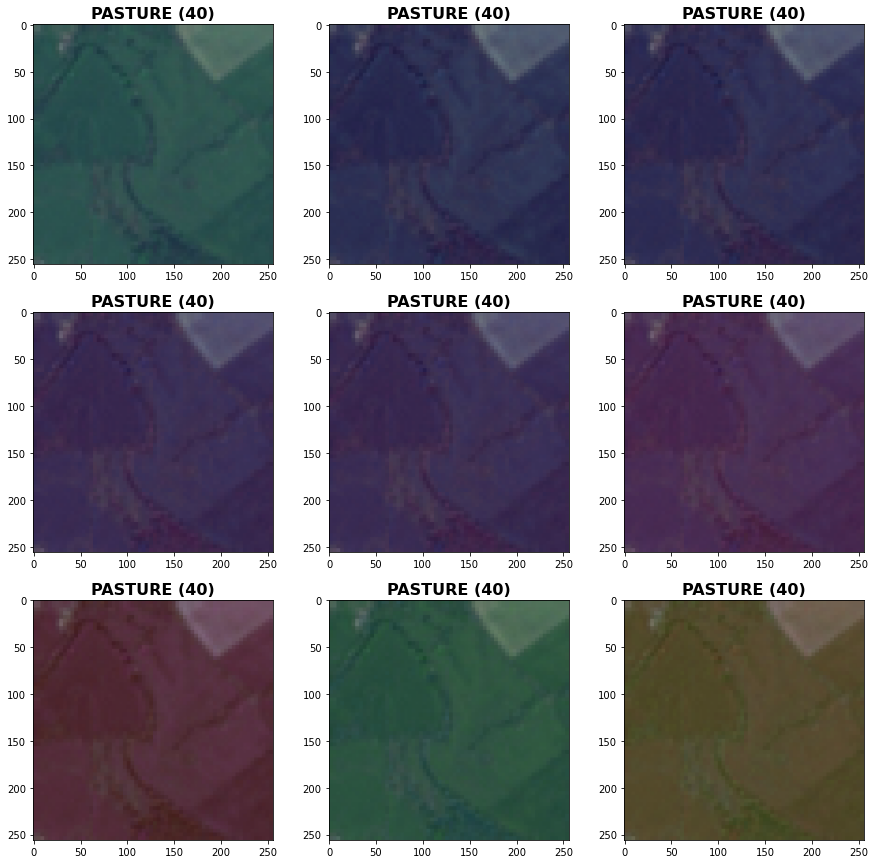

In [488]:
set_seed()
random_hue_DA = lambda image: tf.image.random_hue(image, max_delta=0.5)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3*3):
    row = i//3
    col = i%3
    ax[row][col].set_title(f"{class_name} ({idx})".upper(), fontdict={'size': 16, 'weight': 'bold'})
    if row + col == 0:
        ax[row][col].imshow(sample_image)
    else:
        image_da = random_hue_DA(
            tf.expand_dims(sample_image, axis=0)
        )[0, :, :, :]
        ax[row][col].imshow(image_da)
    

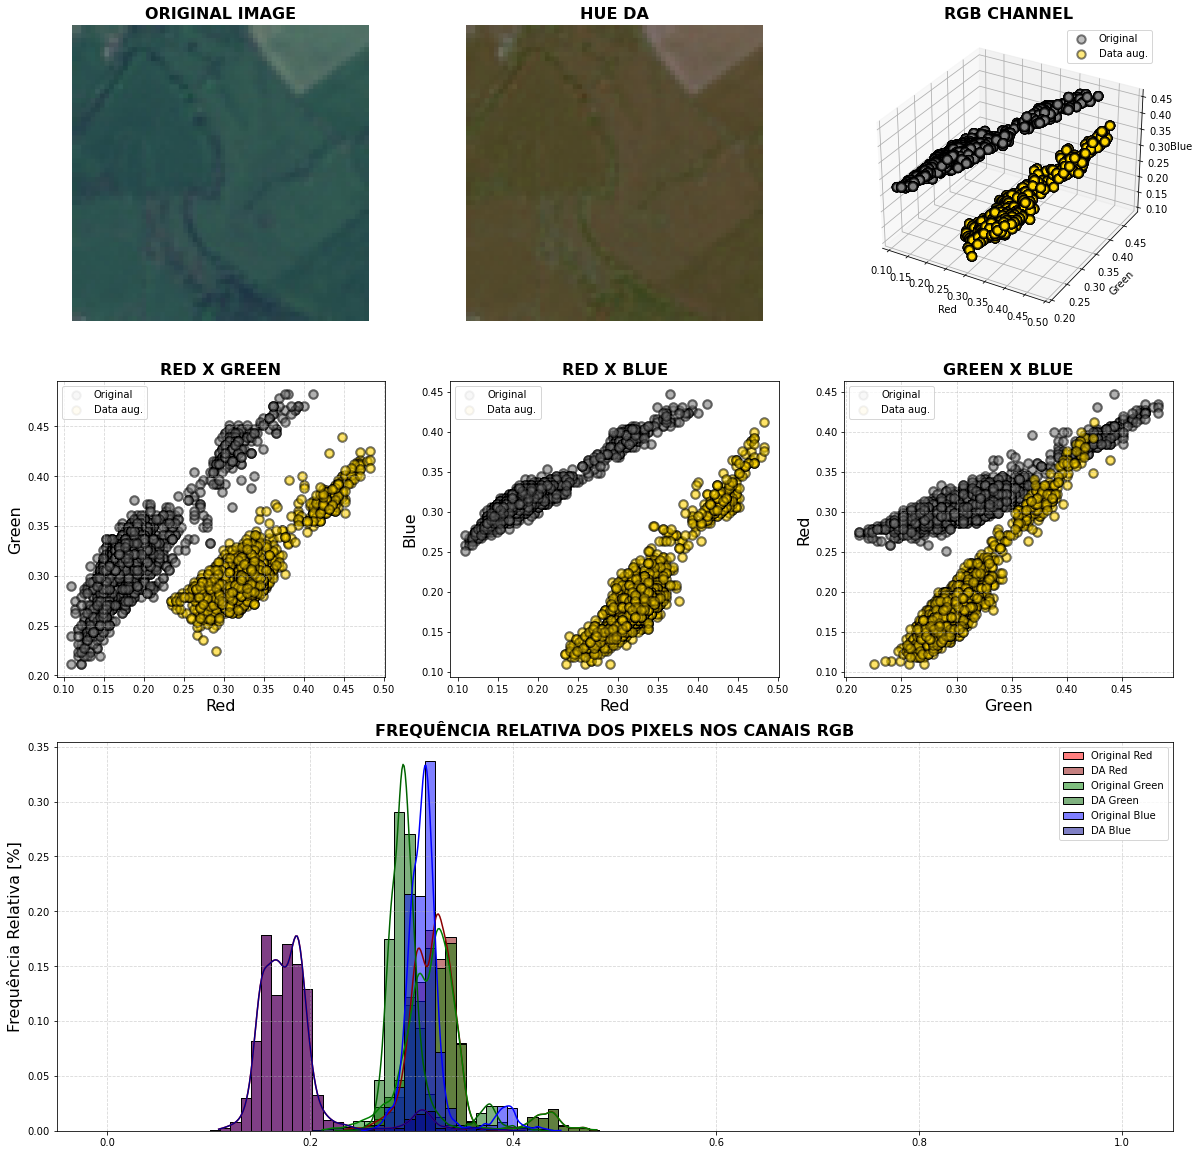

In [489]:
r_da = image_da[:, :, 0].numpy().ravel()
g_da = image_da[:, :, 1].numpy().ravel()
b_da = image_da[:, :, 2].numpy().ravel()

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(2, 3, 1)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"ORIGINAL IMAGE", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(sample_image)
ax.axis('off')

ax = fig.add_subplot(2, 3, 2)
ax.grid(ls='--', alpha=0.5)

ax.set_title(f"HUE DA", fontdict={'size': 16, 'weight': 'bold'})
ax.imshow(image_da)
ax.axis('off')

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.grid(ls='--', alpha=0.5)
ax.set_title("RGB CHANNEL", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter3D(r, g, b, s=70, lw=2, ec='k', color='grey', alpha=0.5, label='Original')
ax.scatter3D(r_da, g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.5, label='Data aug.')
ax.legend()
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')


ax = fig.add_subplot(2, 3, 4)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Green", fontsize=16)
ax.set_title("RED X GREEN", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, g, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, g_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 5)
ax.set_xlabel("Red", fontsize=16)
ax.set_ylabel("Blue", fontsize=16)
ax.set_title("RED X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(r, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(r_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_subplot(2, 3, 6)
ax.grid(ls='--', alpha=0.5)
ax.set_xlabel("Green", fontsize=16)
ax.set_ylabel("Red", fontsize=16)
ax.set_title("GREEN X BLUE", fontdict={'size': 16, 'weight': 'bold'})
ax.scatter(g, b, s=70, lw=2, ec='k', color='grey', alpha=0.05, label='Original')
ax.scatter(g_da, b_da, s=70, lw=2, ec='k', color='gold', alpha=0.05, label='Data aug.')
ax.legend()

ax = fig.add_axes([0.125, -0.4, 0.775, 0.45])
ax.set_title("FREQUÊNCIA RELATIVA DOS PIXELS NOS CANAIS RGB", 
             fontdict={'size': 16, 'weight': 'bold'})
ax.set_ylabel("Frequência Relativa [%]", fontsize=16)
sns.histplot(
    r, label='Original Red', log_scale=False, stat="probability", 
    color='red', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    r_da, label='DA Red', log_scale=False, stat="probability", 
    color='darkred', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    g, label='Original Green', log_scale=False, stat="probability", 
    color='green', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    g_da, label='DA Green', log_scale=False, stat="probability", 
    color='darkgreen', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

sns.histplot(
    b, label='Original Blue', log_scale=False, stat="probability", 
    color='blue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)
sns.histplot(
    b_da, label='DA Blue', log_scale=False, stat="probability", 
    color='darkblue', bins=bins, kde=True, edgecolor="k", 
    linewidth=1, alpha=0.5, ax=ax
)

ax.grid(ls='--', alpha=0.5)
ax.legend()

## Exercise 9
<hr  />

Create new `X_train` and `y_train` datasets, called `X_train_allDA_Pasture` and `y_train_allDA_Pasture` containing all the previously indicated DA techniques:

* Rotation
* Flip
* Zoom
* Contrast
* Brightness
* Hue

You should apply only one DA technique to each sample of the class `Pasture`. Create a classification model similar to the previous ones, showing similar reports (`accuraccy` and `loss` graphics, plus `confusion matrix` and `classification reports`).  

In [548]:
set_seed()

def Xy_data(dataset='train', to_categorical=False):
    classes = {
        'AnnualCrop': 0,
        'Forest': 1,
        'HerbaceousVegetation': 2,
        'Highway': 3,
        'Industrial': 4,
        'Pasture': 5,
        'PermanentCrop': 6,
        'Residential': 7,
        'River': 8,
        'SeaLake': 9
    }
    
    X, y = [], []
    for root, _, files in os.walk(f"{SPATH_IMGS}/{dataset}"):
        for file in files:
            filename = os.path.join(root, file)
            with pimage.open(filename, 'r') as handle:
                X.append(
                    tf.keras.preprocessing.image.img_to_array(handle)/255.
                )
                y.append(classes[filename.split(os.sep)[-2]])
                
    X = np.array(X)
    y = np.array(y)
    if to_categorical:
        y = tf.keras.utils.to_categorical(np.array(y), num_classes=10)
        
    return X, y 


X_train, y_train = Xy_data('train')
X_val, y_val = Xy_data('val')
X_test, y_test = Xy_data('test')      


print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val: X={X_val.shape}, y={y_val.shape}")
print(f"Test: X={X_test.shape}, y={y_test.shape}")

Train: X=(18900, 64, 64, 3), y=(18900,)
Val: X=(4050, 64, 64, 3), y=(4050,)
Test: X=(4050, 64, 64, 3), y=(4050,)


In [577]:
def data_augmentation_unique_class(X, y, idx_class=5):
    global random_rotation_DA, random_flip_DA, andom_zoom_DA
    global random_contrast_DA, random_brightness_DA, random_hue_DA
        
    DA_options = [
        random_rotation_DA,
        random_flip_DA,
        random_zoom_DA,
        random_contrast_DA,
        random_brightness_DA,
        random_hue_DA
    ]
    op = 0
    
    X2, y2 = [], []
    for xx, yy in zip(X, y):
        X2.append(xx)
        y2.append(yy)
        
        if yy == idx_class:
            X2.append(
                DA_options[0](tf.expand_dims(xx, axis=0)).numpy()[0, :, :, :]
            )
            y2.append(yy)
            
    return np.array(X2), np.array(y2)

X_train_DA, y_train_DA = data_augmentation_unique_class(X_train, y_train)
X_val_DA, y_val_DA = data_augmentation_unique_class(X_val, y_val)
# X_test_DA, y_test_DA = data_augmentation_unique_class(X_test, y_test)

print(f"Train: X={X_train_DA.shape}, y={y_train_DA.shape}")
print(f"Val: X={X_val_DA.shape}, y={y_val_DA.shape}")
# print(f"Test: X={X_test_DA.shape}, y={y_test_DA.shape}")

Train: X=(20284, 64, 64, 3), y=(20284,)
Val: X=(4353, 64, 64, 3), y=(4353,)


In [532]:
it.class_indices.values

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [ ]:
class DataAgumentationUniqueClass(object):
    def __init__(self, it, class_name='Pasture'**kw):
        cat_classes = np.zeros(10)
        for i, (k, v) in enumerate(it.class_indices.items()):
            if k == class_name:
                cat_classes[i] = 1.
                break
        for batch_image in it:
            
        
        self.techniques = [
            lambda image: tf.keras.layers.experimental.preprocessing.RandomRotation(
                factor=0.25, 
                fill_mode='reflect', 
                interpolation='bilinear',
                fill_value=0.0
            ),
            lambda image: tf.keras.layers.experimental.preprocessing.RandomFlip(
                mode='horizontal_and_vertical'
            )
        ]

TensorShape([1, 64, 64, 3])

In [512]:
train_it.classes[4066]

1

In [514]:
train_it.

'categorical'